<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Ponto de partida (EDA) </h1> 
</div>

![](img/header.png?t=2021-04-09-00-57-05)

Para essa competição foi disponibilizado uma pasta com diversos arquivos de previsões e um arquivos (<b>train_labels.csv</b>) com os label de cada amostra, os quais devemos combinar para montar os datasets de treino e teste, a tarefa é a de classificação. Cada nome de arquivo na pasta corresponde à pontuação <b>logloss</b> do primeiro metade das linhas de previsão em relação aos rótulos de verdade nesse arquivo. 

A métrica de avaliação é <b>logloss</b> que tem a seguinte formula: 

![](img/lloss.jpg)
    
   

<b>OBSERVAÇÃO SOBRE A METRICA DE AVALIAÇÃO: </b> <br>
A perda logarítmica é indicativa de quão próxima a probabilidade de previsão está do valor real/verdadeiro correspondente (0 ou 1 no caso de classificação binária). Quanto mais a probabilidade prevista diverge do valor real, maior é o valor da perda logarítmica. Na pior das hipóteses, uma previsão de que algo é verdadeiro quando na verdade é falso adicionará uma quantidade infinita à sua pontuação de erro. Para evitar isso, as previsões são limitadas dos extremos por um valor pequeno.  

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados e estabelecer uma linha de base, mostrarei as etapas iniciais de uma competição do Kaggle - desde a compreensão do conjunto de dados até a preparação dos dados para serem usados em um modelo machine learning. 


<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q catboost
    !pip install --q colorama
    #!pip install --q optbinning
    #!pip install --q catboost
    #!pip install --q pandas-profiling
    #!pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

     |████████████████████████████████| 72 kB 505 kB/s 
     |████████████████████████████████| 569 kB 4.6 MB/s 
     |████████████████████████████████| 76.6 MB 1.2 MB/s 
Mounted at /content/drive


## 1.2. Bibliotecas 

In [40]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import multiprocessing
import glob
import glob
import pickle
import scipy.optimize 
import scipy.special

In [41]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import scipy.stats       as stats
import plotly.express    as px
import xgboost           as xgb
import lightgbm          as lgb

In [42]:
from matplotlib.axes._axes     import _log as matplotlib_axes_logger
from sklearn.model_selection   import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.preprocessing     import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer
from sklearn.metrics           import roc_auc_score, f1_score, log_loss, roc_curve, auc
from sklearn.metrics           import classification_report, confusion_matrix
from scipy.stats               import spearmanr

In [43]:
from tqdm.notebook             import tqdm, trange
from datetime                  import datetime
from colorama                  import Fore, Back, Style
from sklearn.calibration       import CalibrationDisplay
from sklearn.feature_selection import SelectPercentile, VarianceThreshold, SelectKBest, f_classif
from sklearn.pipeline          import Pipeline, make_pipeline, FeatureUnion
from sklearn.decomposition     import PCA

In [44]:
from sklearn.linear_model      import LogisticRegression
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.ensemble          import ExtraTreesClassifier   
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.neural_network    import MLPClassifier
from sklearn.ensemble          import RandomForestClassifier
from sklearn.ensemble          import AdaBoostClassifier
from sklearn.ensemble          import HistGradientBoostingClassifier
from sklearn.ensemble          import StackingClassifier

<p style="border-bottom: 3px solid #256B5D"/></p>


## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [30]:
class Utility():
        
    def __init__(self):
        self.name_ =''
       
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        matplotlib_axes_logger.setLevel('ERROR')

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)
        warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

        pd.options.mode.chained_assignment = None 
        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', 200)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(self, df):
        
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(self, df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(self, ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.55*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(self, df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)
        self.graf_label(ax, total)

    def correlation(self, df_, threshold_):
        col_corr    = set()  
        corr_matrix = df_.corr()
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold_: 
                    colname = corr_matrix.columns[i]  
                    col_corr.add(colname)
                    
        return col_corr

    def __graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_='', method_='pearson'):
        
        msg_title = '\n Correlação das variável {} -{} \n'.format(title_, 'method_')
        
        df = df_.copy().corr(method =method_).round(5)
        
        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_
            
            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}                              
                            )

            ax.set_title(msg_title, fontsize=17)
            
            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal", style = 'whitegrid', palette= 'pastel')

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right", style = 'whitegrid', palette= 'pastel')
            
            
            
            plt.show();
            
            
            
        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
        
        #sns.set(style="darkgrid")
        plt.show();
                        
    def describe(self, df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(self, df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(self, t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)
    
    def free_gpu_cache(self):

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval(self):

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(self, y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(self, y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(self, x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(self, data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(self.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(self, df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_='', method_='pearson'):

        df = df_.corr(method=method_).round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            sns.set(style="whitegrid", palette="pastel") 
            
            # Making a plot
            ax = sns.heatmap(df, annot = annot_, 
                             mask      = mask, 
                             cmap      = "RdBu", 
                             fmt       = ".2f",
                             annot_kws = {"weight": "bold", "fontsize":10}
                            )
            
            ax.set_title("\n Correlação das variável {} - {} \n".format(title_, method_.upper()), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")
            
            sns.set(style="darkgrid")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
        return self.correlation(df_, threshold_)

    def plot_roc_curve(self, fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(self, df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(self, df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(self, y_, predictions_, smape_base_=100):
        from sklearn import metrics
        mae   = metrics.mean_absolute_error(y_, predictions_)
        mse   = metrics.mean_squared_error(y_, predictions_)
        rmse  = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape  = metrics.mean_absolute_percentage_error(y_, predictions_)
        smape = self.smape(y_, predictions_)
        r2    = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2, smape
    
    def feature_statistic(self, df, feature_float, feature_cat=None):
        df['fe_mean']        = df[feature_float].mean(axis=1)   
        df['fe_std']         = df[feature_float].std(axis=1)   
        df['fe_median']      = df[feature_float].median(axis=1)   
        df['fe_var']         = df[feature_float].var(axis=1) 
        df['fe_min']         = df[feature_float].min(axis=1)   
        df['fe_max']         = df[feature_float].max(axis=1)   
        df['fe_skew']        = df[feature_float].skew(axis=1)   
        df['fe_quantile_25'] = df[feature_float].quantile(q=.25, axis=1)
        df['fe_quantile_50'] = df[feature_float].quantile(q=.5, axis=1)
        df['fe_quantile_75'] = df[feature_float].quantile(q=.75, axis=1)
        
        if feature_cat is not None:
            df['fe_dammy_count'] = df[feature_cat].sum(axis=1)   
        
        return df
    
    def gridSearchCV(self, model_, params_, X_train_, y_train_):
        """
        @param    model: sklearn estimator
        @param    params (dict): Dictionary of possible parameters

        @return   cv_results (DataFrame)
        """
        model_cv = GridSearchCV(model_, param_grid=params_, scoring='roc_auc', cv=5)
        model_cv.fit(X_train_, y_train_)
        cv_results = pd.DataFrame(model_cv.cv_results_)[['params', 'mean_test_score']]

        return cv_results
    
    def evaluate(self, model,X_train_, y_train_, X_test_, plotROC=False):

        model.fit(X_train_, y_train_)
        probs = model.predict_proba(X_train_)
        preds = probs[:,1]
        fpr, tpr, threshold = roc_curve(y_train_, preds)
        roc_auc = auc(fpr, tpr)
        print(f'AUC: {roc_auc:.4f}')

        rocDf = pd.DataFrame({'fpr': fpr, 'tpr':tpr, 'threshold':threshold})
        rocDf['tpr - fpr'] = rocDf.tpr - rocDf.fpr
        optimalThreshold = rocDf.threshold[rocDf['tpr - fpr'].idxmax()]

        y_pred = np.where(preds >= optimalThreshold, 1, 0)

        # Plot ROC AUC
        if plotROC:
            plt.title('Receiver Operating Characteristic')
            plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
            plt.legend(loc = 'lower right')
            plt.plot([0, 1], [0, 1],'r--')
            plt.xlim([0, 1])
            plt.ylim([0, 1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')
            plt.show()    

    def iqr_outliers(self, df,ft):

        q1  = df[ft].quantile(0.25)
        q3  = df[ft].quantile(0.75)
        iqr = q3-q1
        c   = 0 

        Lower_tail = q1 - 1.5 * iqr
        Upper_tail = q3 + 1.5 * iqr

        for i in range(len(df[ft])):
            if df[ft][i] > Upper_tail or df[ft][i] < Lower_tail:
                c+=1
        return c
    
    def outlier_create_feature_check(self, df_tr_, df_ts_, cols_=[], qt_inferior_=.25, qt_superior_=.75, 
                                     flg_ts_=True, input_limete_=False, verbose_=True):
    
        col_oltlier         = 'fe_outlier'
        df_tr_[col_oltlier] = 0 
        df_ts_[col_oltlier] = 0 

        for c in cols_:

            percentil25 = df_tr_[c].quantile(qt_inferior_)
            percentil75 = df_tr_[c].quantile(qt_superior_)

            iqr= percentil75 - percentil25 

            limite_inferior = percentil25 - 1.5 * iqr
            limite_superior = percentil75 + 1.5 * iqr

            df_tr_[col_oltlier][df_tr_[c]>limite_superior] = -1
            df_tr_[col_oltlier][df_tr_[c]<limite_inferior] = -1

            if input_limete_:
                df_tr_[c][df_tr_[c]>limite_superior] = limite_superior
                df_tr_[c][df_tr_[c]<limite_inferior] = limite_inferior

            if flg_ts_:
                df_ts_[col_oltlier][df_ts_[c]>limite_superior] = -1
                df_ts_[col_oltlier][df_ts_[c]<limite_inferior] = -1
                
                if input_limete_:
                    df_ts_[c][df_ts_[c]>limite_superior] = limite_superior
                    df_ts_[c][df_ts_[c]<limite_inferior] = limite_inferior

            if verbose_:
                print('Com a variável {}'.format(c))
                print(df_tr_[col_oltlier].value_counts())
                print()

        return df_tr_, df_ts_
        
    def calibrated_classifier_graf_model(self, mdl_list_, X_, y_, seed_=12359, figsize_=(10, 10), verbose_=False): 

        fig = plt.figure(1, figsize=figsize_)
        ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
        
        if verbose_: ax2 = plt.subplot2grid((3, 1), (2, 0))

        ax1.plot([0, 1], [0, 1], "k:", label="Perfeitamente calibrado")

        for name, mdl1 in mdl_list_:  
            model_pipeline  = Pipeline(steps=[
                ('preprocessor', preprocessor_1),
                #('sampler_over', over), 
                #('sampler_under', under),    
                ('variancethreshold', VarianceThreshold(threshold=0.1)),    
                ('selectpercentile', SelectPercentile(f_classif, percentile=90)), 
                ('model', mdl1)
                ])

            X_train, X_val, y_train, y_val = train_test_split(X_, y_, test_size=0.5, random_state=seed_)

            model_calibrated = CalibratedClassifierCV(model_pipeline, method='isotonic', cv=2) 
            # method='isotonic' sigmoid

            model_calibrated.fit(X_train, y_train)

            if hasattr(model_calibrated, "predict_proba"):
                prob_pos = model_calibrated.predict_proba(X_val)[:, 1]
            else:  
                prob_pos = model_calibrated.decision_function(X_val)
                prob_pos = (prob_pos-prob_pos.min()) / (prob_pos.max()-prob_pos.min())

            score = brier_score_loss(y_val, prob_pos, pos_label=y_val.max())

            frac_of_pos, mean_pred_value = calibration_curve(y_val, prob_pos, n_bins=15, normalize=True)      

            ax1.plot(mean_pred_value, frac_of_pos, "s-", label="%s (%1.3f)" % (name, score))

            ax1.set_ylabel('Fração de positivos')
            ax1.set_ylim([-0.05, 1.05])
            ax1.legend(loc='upper left' )
            ax1.set_title('\nGráficos de calibração (curva de confiabilidade)\n', fontsize=18)

            if verbose_: 
                ax2.hist(prob_pos, range=(0, 1), bins=100, label=name, histtype="step", lw=2)    
                ax2.set_xlabel('Valor médio previsto')
                ax2.set_ylabel('Quantidade')
                ax2.legend(loc="upper left", ncol=1)

                plt.tight_layout()

                msg = 'AUC: {:2.5f} - F1: {:2.5f} - Perda: {:2.3f} -> {}'
                auc = roc_auc_score(y_val, prob_pos)
                f1  = f1_score(y_val, (prob_pos>.5).astype(int))
                print(msg.format(auc,f1, score, name))

        plt.show()

    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']
        
        return m
        
    def smape(self, a, f):
        return 1/len(a) * np.sum(2 * np.abs(f-a) / (np.abs(a) + np.abs(f))*100)

    def smape_(self, y_true, y_pred, base_=100.):
        denominator          = (np.abs(y_true)+np.abs(y_pred))/base_
        diff                 = np.abs(y_true-y_pred)/denominator
        diff[denominator==0] = 0.0
        return np.nanmean(diff)
    
    def smape_loss(y_true, y_pred):
        """SMAPE Loss"""
        return np.abs(y_true - y_pred) / (y_true + np.abs(y_pred)) * 200
    
    def calc_erro(y, y_pred, outros=True, ruturn_score=False):
        erro   = smape(y, y_pred)    
        
        
        if outros:        
            rmse = metrics.mean_squared_error(y, y_pred, squared=False)
            mape = metrics.mean_absolute_percentage_error(y, y_pred)
            mae  = metrics.mean_absolute_error(y, y_pred)
            
            print('RMSE : {:2.5f}'.format(rmse))
            print('MAE  : {:2.5f}'.format(mae))
            print('MAPE : {:2.5f}'.format(mape))
            
            
        if ruturn_score: 
            return erro
        else: 
            print('SMAPE: {:2.5f}'.format(erro))
            
    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 
                    
    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#
            
            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))
                        
            
            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();
        
    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope
        
    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept
    
    def create_fold(self, path_): 

        paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
                 'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
                 'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
                 'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
                 'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

        for p in paths:
            try:
                os.mkdir(path_+p)       
            except:
                #print('Erro ao criar pasta: {} '.format(path+p))
                pass 
        
utility = Utility()

In [31]:
def read_data(path: str, analyze:bool=True) -> (pd.DataFrame, pd.DataFrame, pd.DataFrame):
    data_dir = Path(path)

    train = pd.read_csv(data_dir / "train.csv")
    test  = pd.read_csv(data_dir / "test.csv")
    submission_df = pd.read_csv(data_dir / "sample_submission.csv")

    if analyze:
        print("=== Shape of Data ===")
        print(f" train data: Rows={train.shape[0]}, Columns={train.shape[1]}")
        print(f" test data : Rows={test.shape[0]}, Columns={test.shape[1]}")

        print("\n=== Train Data: First 5 Rows ===\n")
        display(train.head())
        print("\n=== Train Column Names ===\n")
        display(train.columns)
        print("\n=== Features/Explanatory Variables ===\n")
        eval_features(train)
        print("\n === Skewness ===\n")
        check_skew(train)
    return train, test, submission_df

In [32]:
icecream, colors, color_cols = Utility.jupyter_setting()
n_threads = multiprocessing.cpu_count()

## 1.4. Dataset

### 1.4.1. Descrição de dados

Os dados dessa competição representam o resultados de previsões de modelos, que foram criadas em 5000 arquivos de submissões, cada arquivos tem 40.000 previsões. Temos que fazer a combinação desses arquivos para montar os dataset de treino e teste. 


### 1.4.2. Arquivos 
- <b>train.csv</b>: incluem apenas a variável alvo;
- <b>submission_files</b>: pasta com os arquivos de previões;
- <b>sample_submission.csv</b>: arquivo de envio com as previsões.

### 1.4.3. Estrutura de pasta
A finalidade é criar um estrutura de pasta para armazenar os artefatos criados no processo de análise e modelagem.

In [33]:
path        =  '/content/drive/MyDrive/kaggle/Tabular Playground Series/2022/10 - Novembro/' if COLAB else ''      
path_data   = 'Data/'  
path_automl = 'automl/'
target      = 'label'

utility.create_fold(path)

### 1.4.4. Carrega dados

In [34]:
df1_train     = pd.read_csv(path + path_data + "train_labels.csv")
df_submission = pd.read_csv(path + path_data + "sample_submission.csv")

display(df1_train.head())
print(f" train data: Rows={df1_train.shape[0]}, Columns={df1_train.shape[1]}")
display(df_submission.head())

,id,label
0,0,0
1,1,1
2,2,1
3,3,1
4,4,0


 train data: Rows=20000, Columns=2


,id,pred
0,20000,0.640707
1,20001,0.636904
2,20002,0.392496
3,20003,0.588658
4,20004,0.783603


In [35]:
df_pred       = pd.DataFrame(np.zeros(40000), columns=['id'])
df_pred['id'] = df_pred.index

file_list = sorted(glob.glob(os.path.join(path + path_data, "submission_files/*.csv")))

In [37]:
#df_pred = jb.load(path + path_data + 'pkl/df_pred.pkl.z')

In [39]:
%%time 

for idx, file in enumerate(tqdm(file_list)):
    df_pred[f'pred_{idx}'] = pd.read_csv(file)["pred"].to_numpy()  
    
df_pred.set_index('id', inplace=True)
jb.dump(df_pred, path + path_data + 'pkl/df_pred.pkl.z')

utility.free_gpu_cache()

df_pred.head()

CPU times: total: 0 ns
Wall time: 3.04 ms


,pred_0,pred_1,pred_2,pred_3,pred_4,pred_5,pred_6,pred_7,pred_8,pred_9,pred_10,pred_11,pred_12,pred_13,pred_14,pred_15,pred_16,pred_17,pred_18,pred_19,pred_20,pred_21,pred_22,pred_23,pred_24,pred_25,pred_26,pred_27,pred_28,pred_29,pred_30,pred_31,pred_32,pred_33,pred_34,pred_35,pred_36,pred_37,pred_38,pred_39,pred_40,pred_41,pred_42,pred_43,pred_44,pred_45,pred_46,pred_47,pred_48,pred_49,pred_50,pred_51,pred_52,pred_53,pred_54,pred_55,pred_56,pred_57,pred_58,pred_59,pred_60,pred_61,pred_62,pred_63,pred_64,pred_65,pred_66,pred_67,pred_68,pred_69,pred_70,pred_71,pred_72,pred_73,pred_74,pred_75,pred_76,pred_77,pred_78,pred_79,pred_80,pred_81,pred_82,pred_83,pred_84,pred_85,pred_86,pred_87,pred_88,pred_89,pred_90,pred_91,pred_92,pred_93,pred_94,pred_95,pred_96,pred_97,pred_98,pred_99,pred_100,pred_101,pred_102,pred_103,pred_104,pred_105,pred_106,pred_107,pred_108,pred_109,pred_110,pred_111,pred_112,pred_113,pred_114,pred_115,pred_116,pred_117,pred_118,pred_119,pred_120,pred_121,pred_122,pred_123,pred_124,pred_125,pred_126,pred_127,pred_128,pred_129,pred_130,pred_131,pred_132,pred_133,pred_134,pred_135,pred_136,pred_137,pred_138,pred_139,pred_140,pred_141,pred_142,pred_143,pred_144,pred_145,pred_146,pred_147,pred_148,pred_149,pred_150,pred_151,pred_152,pred_153,pred_154,pred_155,pred_156,pred_157,pred_158,pred_159,pred_160,pred_161,pred_162,pred_163,pred_164,pred_165,pred_166,pred_167,pred_168,pred_169,pred_170,pred_171,pred_172,pred_173,pred_174,pred_175,pred_176,pred_177,pred_178,pred_179,pred_180,pred_181,pred_182,pred_183,pred_184,pred_185,pred_186,pred_187,pred_188,pred_189,pred_190,pred_191,pred_192,pred_193,pred_194,pred_195,pred_196,pred_197,pred_198,pred_199,pred_200,pred_201,pred_202,pred_203,pred_204,pred_205,pred_206,pred_207,pred_208,pred_209,pred_210,pred_211,pred_212,pred_213,pred_214,pred_215,pred_216,pred_217,pred_218,pred_219,pred_220,pred_221,pred_222,pred_223,pred_224,pred_225,pred_226,pred_227,pred_228,pred_229,pred_230,pred_231,pred_232,pred_233,pred_234,pred_235,pred_236,pred_237,pred_238,pred_239,pred_240,pred_241,pred_242,pred_243,pred_244,pred_245,pred_246,pred_247,pred_248,pred_249,...,pred_4750,pred_4751,pred_4752,pred_4753,pred_4754,pred_4755,pred_4756,pred_4757,pred_4758,pred_4759,pred_4760,pred_4761,pred_4762,pred_4763,pred_4764,pred_4765,pred_4766,pred_4767,pred_4768,pred_4769,pred_4770,pred_4771,pred_4772,pred_4773,pred_4774,pred_4775,pred_4776,pred_4777,pred_4778,pred_4779,pred_4780,pred_4781,pred_4782,pred_4783,pred_4784,pred_4785,pred_4786,pred_4787,pred_4788,pred_4789,pred_4790,pred_4791,pred_4792,pred_4793,pred_4794,pred_4795,pred_4796,pred_4797,pred_4798,pred_4799,pred_4800,pred_4801,pred_4802,pred_4803,pred_4804,pred_4805,pred_4806,pred_4807,pred_4808,pred_4809,pred_4810,pred_4811,pred_4812,pred_4813,pred_4814,pred_4815,pred_4816,pred_4817,pred_4818,pred_4819,pred_4820,pred_4821,pred_4822,pred_4823,pred_4824,pred_4825,pred_4826,pred_4827,pred_4828,pred_4829,pred_4830,pred_4831,pred_4832,pred_4833,pred_4834,pred_4835,pred_4836,pred_4837,pred_4838,pred_4839,pred_4840,pred_4841,pred_4842,pred_4843,pred_4844,pred_4845,pred_4846,pred_4847,pred_4848,pred_4849,pred_4850,pred_4851,pred_4852,pred_4853,pred_4854,pred_4855,pred_4856,pred_4857,pred_4858,pred_4859,pred_4860,pred_4861,pred_4862,pred_4863,pred_4864,pred_4865,pred_4866,pred_4867,pred_4868,pred_4869,pred_4870,pred_4871,pred_4872,pred_4873,pred_4874,pred_4875,pred_4876,pred_4877,pred_4878,pred_4879,pred_4880,pred_4881,pred_4882,pred_4883,pred_4884,pred_4885,pred_4886,pred_4887,pred_4888,pred_4889,pred_4890,pred_4891,pred_4892,pred_4893,pred_4894,pred_4895,pred_4896,pred_4897,pred_4898,pred_4899,pred_4900,pred_4901,pred_4902,pred_4903,pred_4904,pred_4905,pred_4906,pred_4907,pred_4908,pred_4909,pred_4910,pred_4911,pred_4912,pred_4913,pred_4914,pred_4915,pred_4916,pred_4917,pred_4918,pred_4919,pred_4920,pred_4921,pred_4922,pred_4923,pred_4924,pred_4925,pred_4926,pred_4927,pred_4928,pred_4929,pred_4930,pred_4931,pred_4932,pred_4933,pred_4934,pred_

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. Análise Exploratória de Dados (EDA) </h1>    
</div>

Antes de trabalhar com qualquer tipo de dados é importante entendê-los. Um passo crucial para esse objetivo é a Análise Exploratória de Dados (EDA): uma combinação de visualizações e análise estatística (uni, bi e multivariada) que nos ajude a entender melhor os dados com os quais estamos trabalhando e obter insights sobre seus relacionamentos.

In [45]:
df2_train = df_pred[:df1_train.shape[0]].copy() 
df2_test  = df_pred[df1_train.shape[0]:].reset_index(drop=True)

df2_train[target] = df1_train[target]

## 2.1. Dimensão do DataSet

In [ ]:
print('TREINO')
print('Numero de linhas : {}'.format(df2_train.shape[0]))
print('Numero de colunas: {}'.format(df2_train.shape[1]), end='\n\n')

print('TESTE')
print('Numero de linhas : {}'.format(df2_test.shape[0]))
print('Numero de colunas: {}'.format(df2_test.shape[1]), end='\n\n')

TREINO
Numero de linhas : 20000
Numero de colunas: 54

TESTE
Numero de linhas : 20000
Numero de colunas: 53



## 2.2. Tipo de dados

In [ ]:
df2_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Columns: 5001 entries, pred_0 to label
dtypes: float64(5000), int64(1)
memory usage: 763.2 MB


## 2.3. Identificar NA

In [ ]:
missing = utility.missing_zero_values_table(df2_train)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 5001 colunas e 20000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


In [ ]:
missing = utility.missing_zero_values_table(df2_test)
missing[:].style.background_gradient(cmap='Reds')

Seu dataframe selecionado tem 5000 colunas e 20000 linhas. 
Existem 0 colunas com valores ausentes.


,index,Valores ausentes,% de valores totais,Tipo de dados


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
Não temos valores ausentes. 

    
</div>

## 2.4. Outliers 

In [ ]:
print('Valores mínimos e máximos') 
for _ in [('Treino', df2_train), ('Teste ', df2_test)]: 
    msg = '{}: {} / {} => ({}/{})' 
    _min, _max      = _[1].values.min(),_[1].values.max()
    _abaixo, _acima = (_[1].values<0).sum(), (_[1].values>1).sum() 
    print(msg.format(_[0], _min, _max, _abaixo, _acima ))
        
del _min, _max, _abaixo, _acima

Valores mínimos e máximos
Treino: -0.336521 / 1.356611 => (958/7996)
Teste : -0.376186 / 1.311234 => (1009/7596)


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
Observamos que temos valores negativo e acima de 1, isso é um indicativo que que devemos fazer a exclusão desses valores discrepantes, por ser tratar de probabilidade devem ficar entre 0 e 1. Com a exclusão desses valores discrepantes vamos ter um redução no número de variáveis. 

    
</div>

## 2.5. Dados duplicados

In [ ]:
_ = pd.DataFrame(df2_train.sum()).reset_index().set_index('index')
_.columns = ['values']
_[_['values'].duplicated()]

,values
index,


<p style="border-bottom: 2px solid #256B5D"/></p>


## 2.6. Nomes de arquivos e perda de log

In [ ]:
_start        = len(file_list[0])-16 
log_loss_list = []
y             = df2_train[target]

print('name                          log loss')
for sub in range(5):
    name_loss = float(file_list[sub][_start:-4])
    print(file_list[sub][_start:], name_loss , log_loss(y, df2_train.values[:,sub]))

for sub in range(df2_train.shape[1]-1):    
    name_loss = float(file_list[sub][_start:-4])
    log_loss_list.append(name_loss)

name                          log loss
0.6222863195.csv 0.6222863195 0.6222863195129075
0.6223807245.csv 0.6223807245 0.6223807245068153
0.6225426578.csv 0.6225426578 0.622542657774157
0.6247722291.csv 0.6247722291 0.6247722290993437
0.6253455681.csv 0.6253455681 0.6253455680841075


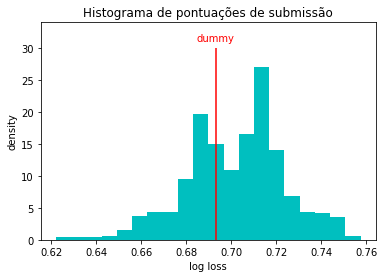

In [ ]:
plt.hist(log_loss_list, bins=20, density=True, color='c')
plt.vlines([log_loss(y, np.full(len(y), 0.5))], 0, 30, color='r')
plt.text(0.693, 31, 'dummy', color='r', ha='center')
plt.title('Histograma de pontuações de submissão')
plt.xlabel('log loss')
plt.ylabel('density')
plt.ylim(0, 34)
plt.show()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
O histograma das pontuações mostram que todos os modelos apresentam log loss entre 0,622 e 0,758, um modelo fictício que prevê 0,5 tem uma perda logarítmica de 0,693 (linha vermelha no diagrama), sendo assim, podemos considerar essas pontuações fracas. Um modelo perfeito teria uma perda logarítmica de 0. <p><br>

<b>Insight:</b> <br>
- Metade dos modelos de entrada são piores do que um classificador fictício! 
- Devemos descartar essas variáveis (modelos) imediatamente? Não, embora essas colunas tenham logloss alto, elas ainda contêm informações que podem ser valiosas para um classificador (modelo).<p><br>
    


</div>

### 2.6.1. Média do Modelo

É uma boa ideia verificar a previsão média de todo o conjunto de dados. Para isso vou dividir a previsão com base no rótulo verdadeiro de treinamento e verificar se o modelo tem bom desempenho.

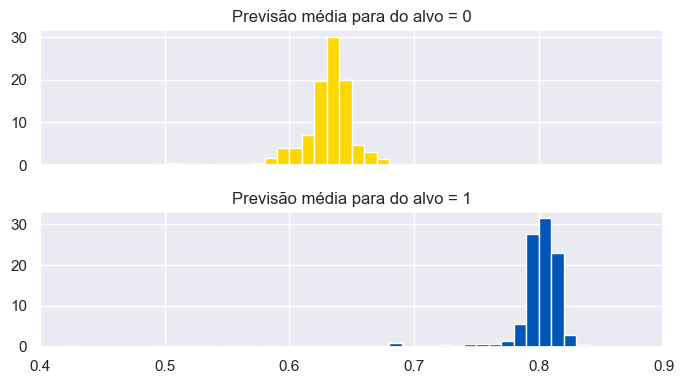

In [159]:
train_targe_0 = df2_train[df2_train[target]==0].mean().drop(target)
train_targe_1 = df2_train[df2_train[target]==1].mean().drop(target)

fig, axs = plt.subplots(2, 1, figsize=(7, 4), sharex=True) 
axs[0].hist(train_targe_0, range=(0, 1), bins=100, density=True, color='#ffd700', label='Target 0')
axs[1].hist(train_targe_1, range=(0, 1), bins=100, density=True, color='#0057b8', label='Target 1')
axs[0].set_xlim([0.4, 0.9])
axs[1].set_xlim([0.4, 0.9])
axs[0].set_title('Previsão média para do alvo = 0')
axs[1].set_title('Previsão média para do alvo = 1')
plt.tight_layout();

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
- A maioria das previsões para <b>target==0</b> são desviadas para valores mais baixos e o mesmo comportamento se aplica a <b>target==1</b>. <p>
    
- Nem todos os modelos vão ter o mesmo desempenho, existem discrepâncias para ambas as classes; <p>
    
- Podemos cria uma variável que indique essa discrepância.    
    
    
</div>

## 2.7. Distribuição

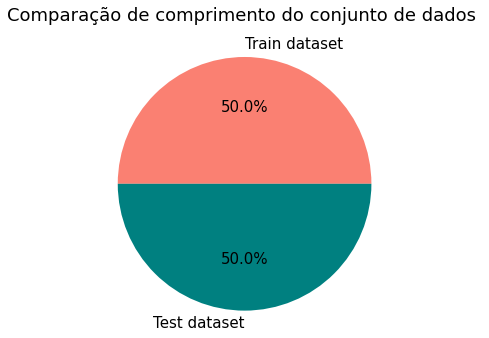

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df2_train), len(df2_test)],
             labels   = ["Train dataset", "Test dataset"],
             colors   = ["salmon", "teal"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')

ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

### 2.7.1. Distribuição Train x Test

In [ ]:
feature_sample = df2_test.sample(27, axis='columns').columns.to_list()

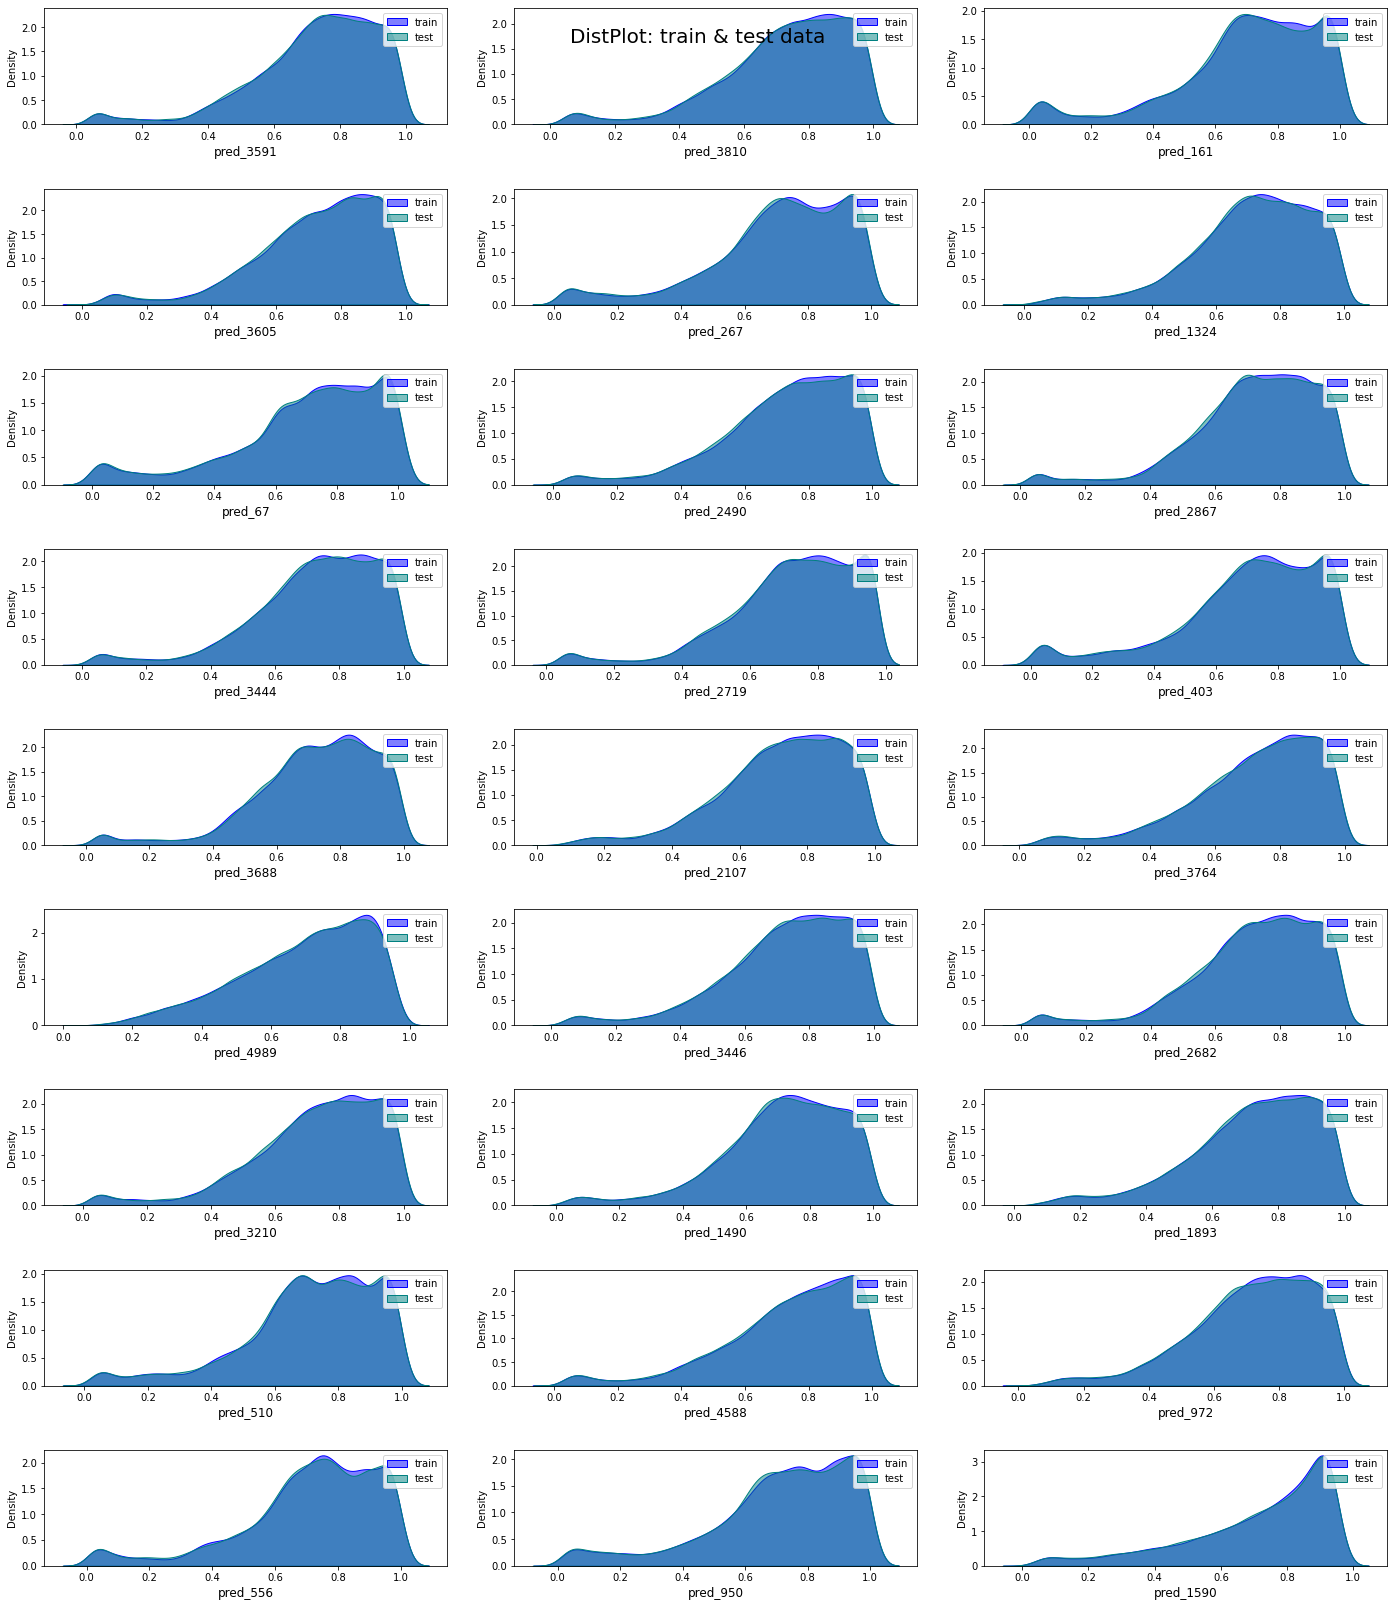

In [ ]:
lines   = int(len(feature_sample)/2)+1

plt.figure(figsize=(20,35))

for i,feature in enumerate(feature_sample):
    plt.subplot(lines,3,i+1)
    sns.kdeplot(df2_train[feature],color='blue', alpha=0.5, label='train', shade=True)
    sns.kdeplot(df2_test[feature] ,color='teal', alpha=0.5, label='test', shade=True)  
    plt.xlabel(feature, fontsize=12);
    plt.legend();

plt.suptitle('DistPlot: train & test data', fontsize=20)
plt.tight_layout(pad=3.0);

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
Observamos que os dados de treino e teste seguem a mesma distribuição, porém a maioria dos dados da amostra apresentam assimetria longa, indicando um boa quantidade de outliers. Talvez uma normalização pode ajudar na assimetria.  
    
</div>

### 2.7.2. Distribuição da target

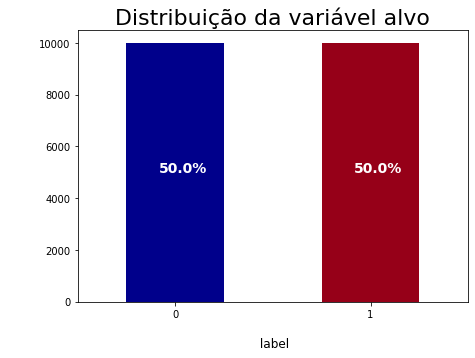

In [ ]:
plt.figure(figsize=(7,5))  
_ = df2_train.groupby([target])[target].count()
utility.graf_bar(_,icecream,'Distribuição da variável alvo',target, '');


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
Os dados são equilibrados, como se trata de previsões provavelmente foram balaceados.   
    
</div>

## 2.8. Correlação

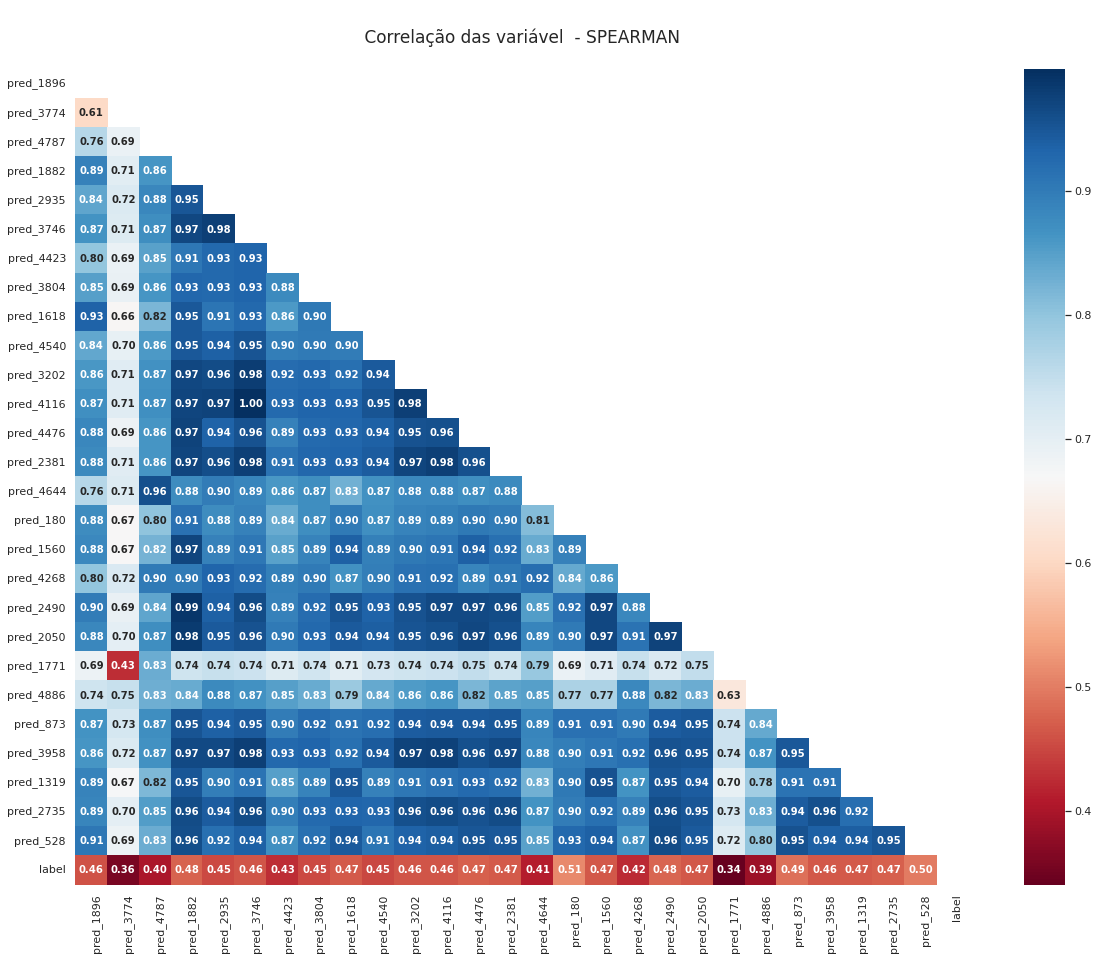

In [ ]:
plt.figure(figsize=(20,15))

feature_corr = \
    utility.graf_feature_corr(df_         = df2_train[feature_sample+[target]],                             
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman'
                              );
utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
Observamos que as variávies tem uma baixa correlação com a variável preditora, nesta amostra, outro ponto é alta correção entre as variáveis, isso é explicado por se tratarem de variáveis de previsões geradas por modelos. A remoção dessas variáveis autocorrelacionadas podem melhorar a perfomance de alguns modelos. <p> <br>  
        
</div>

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. MODELAGEM </h1>    
</div>

Nesta parte do processo vamos utilizar os seguintes classificadores para gerar os modelos: 
<b>
- LogisticRegression;
- KNeighborsClassifier; 
- MLPClassifier; 
- XGBClassifier; 
- ExtraTreesClassifier; 
- RandomForestClassifier;
- HistGradientBoostingClassifier. 
</b> <br> <p>

Com esses modelos a idéia é gerar previsões que serão incluídas ao dateset de primeiro nível. <p> 

Para cada modelo, traçamos o histograma de previsão e a curva de calibração de probabilidade. A calibração de probabilidade é importante porque essa competição não é sobre precisão, mas sobre previsão exata de probabilidades. <p>

Cada modelo é treinado em 10 folds gerando previsões que são armazenadas em arquivos para serem utilizadas mais tarde em outros notebooks, tmbém serão gerados os arquivos para submissões com o nome dos modelos.  <p> 

Neste primeiro momento vamos apenas remover as variáveis com pouca variância para a modelagem, dentro de <b>pipeline</b> de treinamento. 


## 3.1. Train / teste

In [77]:
seed = 12359

In [160]:
%%time 

X      = df2_train.copy()
X_test = df2_test.copy()
y      = df2_train[target]

X.drop([target], axis=1, inplace=True)
X.shape, X_test.shape

CPU times: total: 2.59 s
Wall time: 23.4 s


((20000, 5000), (20000, 5000))

## 3.2. Classificadores e pipeline

In [154]:
# Paremetros 

params_xgb  = {
    'objective'        : 'binary:logistic',
    'eval_metric'      : 'logloss',
    'max_depth'        : 7,  
    'colsample_bytree' : 0.8, 
    'max_leaves'       : 10,    # 0.52463    
    'subsample'        : 0.95,  # 0.52460      
    
    #'lambda'           : 1.2,
    #'alpha'            : 0.9,   # 
    #'min_child_weight' : 1e-3,
    #'colsample_bylevel': 0.95,    
    # 'learning_rate'    : 1e-1,
     #'sampling_method'  : 'uniform',  # 0.52460   
    'n_jobs'           : -1,
    'seed'             : seed}

param_lgbm  = {
    'objective'         : 'binary',
    'metric'            : 'binary_logloss',
    'colsample_bytree'  : 0.5139258065278501,
    'learning_rate'     : 0.02,
    'max_depth'         : 6,
    'min_child_samples' : 219,
    'min_child_weight'  : 1e-05,
    'n_estimators'      : 300,
    'num_leaves'        : 128,
    'reg_alpha'         : 1,
    'reg_lambda'        : 0,
    'subsample'         : 0.8116483602711031,         
    #'device'            : 'gpu',    
    'random_state'      : seed}

param_rf    = {
    'class_weight'      : 'balanced', 
    'n_estimators'      : 100,
    'max_depth'         : 7,    # 0.52808
    'min_samples_split' : 5,    # 0.52804    
    'min_samples_leaf'  : 20,   #  0.52705
    'random_state'      : seed}

param_ext   = {
    'n_estimators'     : 500,
    'max_depth'        : 7, 
    'min_samples_leaf' : 12,         
    'n_jobs'           : -1,
    'random_state'     : seed}

param_lr    = {
    'max_iter'      : 1000, 
    'C'             : 0.0001, 
    'penalty'       : 'l2', 
    'fit_intercept' : True,
    'solver'        : 'newton-cg'}

param_mlp   = {
    'learning_rate' : 'adaptive',
    'alpha'         : 0.5,
    'random_state'  : seed}

param_hbc   = {
    'max_iter'            : 100,
    'validation_fraction' : 0.1,
    'random_state'        : seed}

if torch.cuda.is_available():           
    params_xgb.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

# Classificadores
model_lr   = LogisticRegression(**param_lr)
model_knn  = KNeighborsClassifier(n_neighbors=225)
model_mlp  = MLPClassifier(**param_mlp) 
model_xgb  = xgb.XGBClassifier(**params_xgb) 
model_ext  = ExtraTreesClassifier(**param_ext)
model_lgbm = lgb.LGBMClassifier(**param_lgbm)
model_rf   = RandomForestClassifier(**param_rf)
model_hbc  = HistGradientBoostingClassifier(**param_hbc)

pca    = ('pca', PCA(n_components=80, random_state=seed))
scaler = StandardScaler() 

# Processamento
processar         = ('preprocessor', scaler)
variancethreshold = ('variancethreshold', VarianceThreshold(threshold=1.0e-03)) 
selectpercentile  = ('selectpercentile', SelectPercentile(f_classif, percentile=98))
selectKbest       = ('SelectKBest', SelectKBest(score_func=f_classif))

# Pipelne 
pipeline_lr   = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_lr)])
pipeline_knn  = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_knn)])
pipeline_mlp  = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_mlp)])
pipeline_xgb  = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_xgb)])
pipeline_ext  = Pipeline(steps=[processar, variancethreshold, selectpercentile, ('model', model_ext)])
pipeline_lgbm = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_lgbm)])
pipeline_rf   = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_rf)])
pipeline_hbc  = Pipeline(steps=[variancethreshold, selectpercentile, ('model', model_hbc)])

## 3.3. Funções da modelagem

In [80]:
def delete_files(namefile):

        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'
                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):                    
                        os.remove(os.path.join(raiz, arquivo))

In [81]:
def save_data_model(model_, model_name_, path_, y_pred_train_prob_, y_pred_test_prob_, y_pred_test_submission_, 
                    score_, seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_)  + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_)  + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_)  + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(y_pred_train_prob_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            df_submission[target_] = y_pred_test_submission_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [82]:
def f1_eval(y_pred, dtrain): 
    # https://stackoverflow.com/questions/51587535/custom-evaluation-function-based-on-f1-for-use-in-xgboost-python-api
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err    

In [83]:
def plot_metric(result):
    plt.figure(figsize=(16, 4))
    
    for i, metric in enumerate(['logloss']):
        plt.subplot(1, 2, i+1)
        train_metric = result['train'][metric]
        plt.plot(train_metric, label=f'train {metric}')
        eval_metric = result['valid'][metric]
        plt.plot(eval_metric, label=f'valid {metric}')
        plt.grid()
        plt.legend()
        plt.xlabel('rounds')
        plt.ylabel(f'{metric}')
    plt.show()

In [1]:
def model_cv_fit(models_, X_, y_, X_test_, path_, target_=target, seed_=12359, print_report_=False,
                 n_splits_=5, print_hist_=False, create_sub_=False, var_th_=1.0e-03, save_ensamble_=True):
    
    cols        = []
    cols_score  = []
    oof_train   = np.zeros((len(X_), len(models_)))
    score_mdl   = np.zeros(len(models_),)
    oof_test    = np.zeros((len(X_test_), len(models_)))
    kf          = StratifiedKFold(shuffle=True, n_splits=n_splits_, random_state=seed_)        
    X_ts        = scipy.special.logit(X_test_.clip(1e-6, 1-1e-6))
    
    for i, m in enumerate(models_):
        
        time_start  = datetime.now()        
        model       = m[1]
        type_model  = m[2]
        name_sub    = m[3]
        score_list  = []
        y_ts_pred   = 0 
        
        delete_files(name_sub)
        
        print()
        print('=> {}'.format(m[0]))
        print('='*73)

        for fold, (idx_tr, idx_va) in enumerate(kf.split(X_, y_)):
            
            time_fold_start = datetime.now()
            
            X_tr = scipy.special.logit(X_.iloc[idx_tr].clip(1e-6, 1-1e-6))
            X_va = scipy.special.logit(X_.iloc[idx_va].clip(1e-6, 1-1e-6))
            y_tr = y_.iloc[idx_tr]
            y_va = y_.iloc[idx_va]
            
            if type_model==1:
                model.fit(X_tr, y_tr)

            if type_model==2:
                model.fit(X_tr, y_tr, 
                          model__eval_set=[(X_va, y_va)], 
                          model__eval_metric ='binary_logloss', 
                          model__callbacks= early_stopping_rounds [early_stopping(100)]
                          )


            y_va_pred  = model.predict_proba(X_va)[:,1]
            y_ts_pred += model.predict_proba(X_ts)[:,1]/kf.n_splits                      
            logloss    = log_loss(y_va, y_va_pred) 
            f1         = f1_score(y_va, (y_va_pred>.5).astype(int))
            roc_auc    = roc_auc_score(y_va, (y_va_pred>.5).astype(int))            
            
            oof_train[idx_va, i] = y_va_pred
            
            time_fold_end = utility.diff(time_fold_start, datetime.now())
            
            msg = "Fold {} => L.Loss: {:2.5f} - F1-score: {:2.5f} - AUC:{:2.5f} - {}"            
            print(msg.format(fold+1,logloss,f1,roc_auc, time_fold_end))
            
            score_list.append(logloss)

        oof_test[:,i] = y_ts_pred
        score_mean    = np.mean(score_list).round(5)
        
        if print_hist_: 
            plot_oof_histogram(m[0], oof_train)
        
        cols.append(m[0])
        cols_score.append(m[0]+'_'+str(score_mean))
                
        if create_sub_:
            if target_ is None: target_=target
            name_sub = name_sub+'_{:2.5f}_folds_{}_oof.csv'.format(score_mean, n_splits_)

            save_data_model(model_                  = model, 
                            model_name_             = name_sub, 
                            path_                   = path_, 
                            y_pred_train_prob_      = oof_train[:, i], 
                            y_pred_test_prob_       = oof_test[:,i], 
                            y_pred_test_submission_ = oof_test[:,i], 
                            score_                  = score_mean, 
                            seed_                   = seed_, 
                            level_                  = '1', 
                            target_                 = target_, 
                            cutoff_value_           = .1, 
                            gera_submission_        = True)  
        
        score_mdl[i] = score_mean
        
        time_end = utility.diff(time_start, datetime.now()) 
        
        print('-'*73)
        print(f'{Fore.GREEN}{Style.BRIGHT}[Fold Mean] L.Loss: {score_mean:.5f}{Style.RESET_ALL} - {time_end}') 
        print('='*73)
        
        if print_report_: 
            y_pred = (oof_train[:, i]>.5).astype(int)
            print()
            print(classification_report(y_, y_pred))
            print(confusion_matrix(y_, y_pred))    

        utility.free_gpu_cache()
           
    df_oof_tr    = pd.DataFrame(oof_train, columns=cols_score) 
    df_oof_ts    = pd.DataFrame(oof_test, columns=cols_score) 
    df_score_mdl = pd.DataFrame(score_mdl, columns= ['score'])
    
    df_score_mdl.index = cols    
    df_score_mdl       = df_score_mdl.sort_values(by='score',ascending=True)  
    
    if save_ensamble_:
        jb.dump(df_oof_tr, path_ + 'Data/pkl/df_pred_tr.pkl.z')
        jb.dump(df_oof_ts, path_ + 'Data/pkl/df_pred_ts.pkl.z');

    display(df_score_mdl)
    print()
    
    return df_oof_tr, df_oof_ts, df_score_mdl

NameError: name 'target' is not defined

## 3.4. Treino

In [85]:
%%time

models = [ 
    ('LR', pipeline_lr, 1, 'lr_nb_01'), 
    ('KNN', pipeline_knn, 1, 'knn_nb_01'),     
    ('MLP', pipeline_mlp, 1, 'mlp_nb_01' ),
    ('XGB', pipeline_xgb, 1, 'xgb_nb_01'),    
    ('ExTrees', pipeline_ext, 1, 'extrees_nb_01'),    
    ('LGBM', pipeline_lgbm, 1, 'lgbm_nb_01'), 
    ('RForest', pipeline_rf, 1, 'rforest_nb_01'),
    ('HBoosting', pipeline_hbc, 1,'hboosting_nb_01')]

df_pred_tr, df_pred_ts, df_score_mdl = \
    model_cv_fit(models_       = models, 
                 X_            = X,
                 y_            = y, 
                 X_test_       = X_test,                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = 'pred',
                 create_sub_   = True, 
                 n_splits_     = 10,
                 print_report_ = True)


=> LR
Fold 1 => L.Loss: 0.52440 - F1-score: 0.71885 - AUC:0.72700 - 0h 2m 15s
Fold 2 => L.Loss: 0.50753 - F1-score: 0.73546 - AUC:0.73850 - 0h 0m 31s
Fold 3 => L.Loss: 0.53385 - F1-score: 0.70251 - AUC:0.70950 - 0h 0m 28s
Fold 4 => L.Loss: 0.51997 - F1-score: 0.72567 - AUC:0.73500 - 0h 0m 29s
Fold 5 => L.Loss: 0.53124 - F1-score: 0.70806 - AUC:0.71550 - 0h 0m 28s
Fold 6 => L.Loss: 0.52532 - F1-score: 0.70208 - AUC:0.71400 - 0h 0m 31s
Fold 7 => L.Loss: 0.51411 - F1-score: 0.71622 - AUC:0.72700 - 0h 0m 29s
Fold 8 => L.Loss: 0.52221 - F1-score: 0.72718 - AUC:0.73850 - 0h 0m 30s
Fold 9 => L.Loss: 0.53990 - F1-score: 0.69443 - AUC:0.70650 - 0h 0m 31s
Fold 10 => L.Loss: 0.54709 - F1-score: 0.69453 - AUC:0.70400 - 0h 0m 26s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52656 - 0h 6m 52s

              precision    recall  f1-score   support

           0       0.71      0.75      0.73     10000
           1       0.74      0.69      0.71     

Fold 1 => L.Loss: 0.52295 - F1-score: 0.71904 - AUC:0.73000 - 0h 1m 3s
Fold 2 => L.Loss: 0.50800 - F1-score: 0.73625 - AUC:0.74100 - 0h 1m 2s
Fold 3 => L.Loss: 0.53199 - F1-score: 0.70253 - AUC:0.71250 - 0h 1m 4s
Fold 4 => L.Loss: 0.51857 - F1-score: 0.72225 - AUC:0.73350 - 0h 1m 5s
Fold 5 => L.Loss: 0.53059 - F1-score: 0.70351 - AUC:0.71300 - 0h 1m 4s
Fold 6 => L.Loss: 0.52804 - F1-score: 0.70236 - AUC:0.71650 - 0h 1m 3s
Fold 7 => L.Loss: 0.51572 - F1-score: 0.71414 - AUC:0.72900 - 0h 1m 4s
Fold 8 => L.Loss: 0.52514 - F1-score: 0.72152 - AUC:0.73600 - 0h 1m 3s
Fold 9 => L.Loss: 0.54225 - F1-score: 0.69665 - AUC:0.71000 - 0h 1m 3s
Fold 10 => L.Loss: 0.54725 - F1-score: 0.69538 - AUC:0.70650 - 0h 1m 3s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52705 - 0h 10m 40s

              precision    recall  f1-score   support

           0       0.71      0.76      0.73     10000
           1       0.74      0.68      0.71     10000

    accur

,score
LGBM,0.52476
LR,0.52656
RForest,0.52705
HBoosting,0.52772
ExTrees,0.53159
KNN,0.54191
MLP,0.55599
XGB,0.62340



CPU times: total: 13h 39min 2s
Wall time: 2h 36min 46s


<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Nas submissões todos os modelos tiveram score melhor que no treinamento na LB pública, o melhor modelo foi <b>LGBM</b>, abaixo as submissÕes:

- <b>0.51562 -> LGBMClassifier</b>;
- 0.51652 -> HistGradientBoostingClassifier. 
- 0.51592 -> XGBClassifier; 
- 0.51998 -> RandomForestClassifier;
- 0.52082 -> LogisticRegression;
- 0.52294 -> ExtraTreesClassifier; 
- 0.53570 -> KNeighborsClassifier; 
- 0.58567 -> MLPClassifier; 

</div>

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 4. ANÁLISE DAS PREVISÕES </h1>    
</div>

## 4.1. Distribuição e calibração

In [86]:
#df_pred_tr = jb.load(path+path_data +'pkl/df_pred_tr.pkl.z' )
#df_pred_ts = jb.load(path+path_data +'pkl/df_pred_ts.pkl.z' )

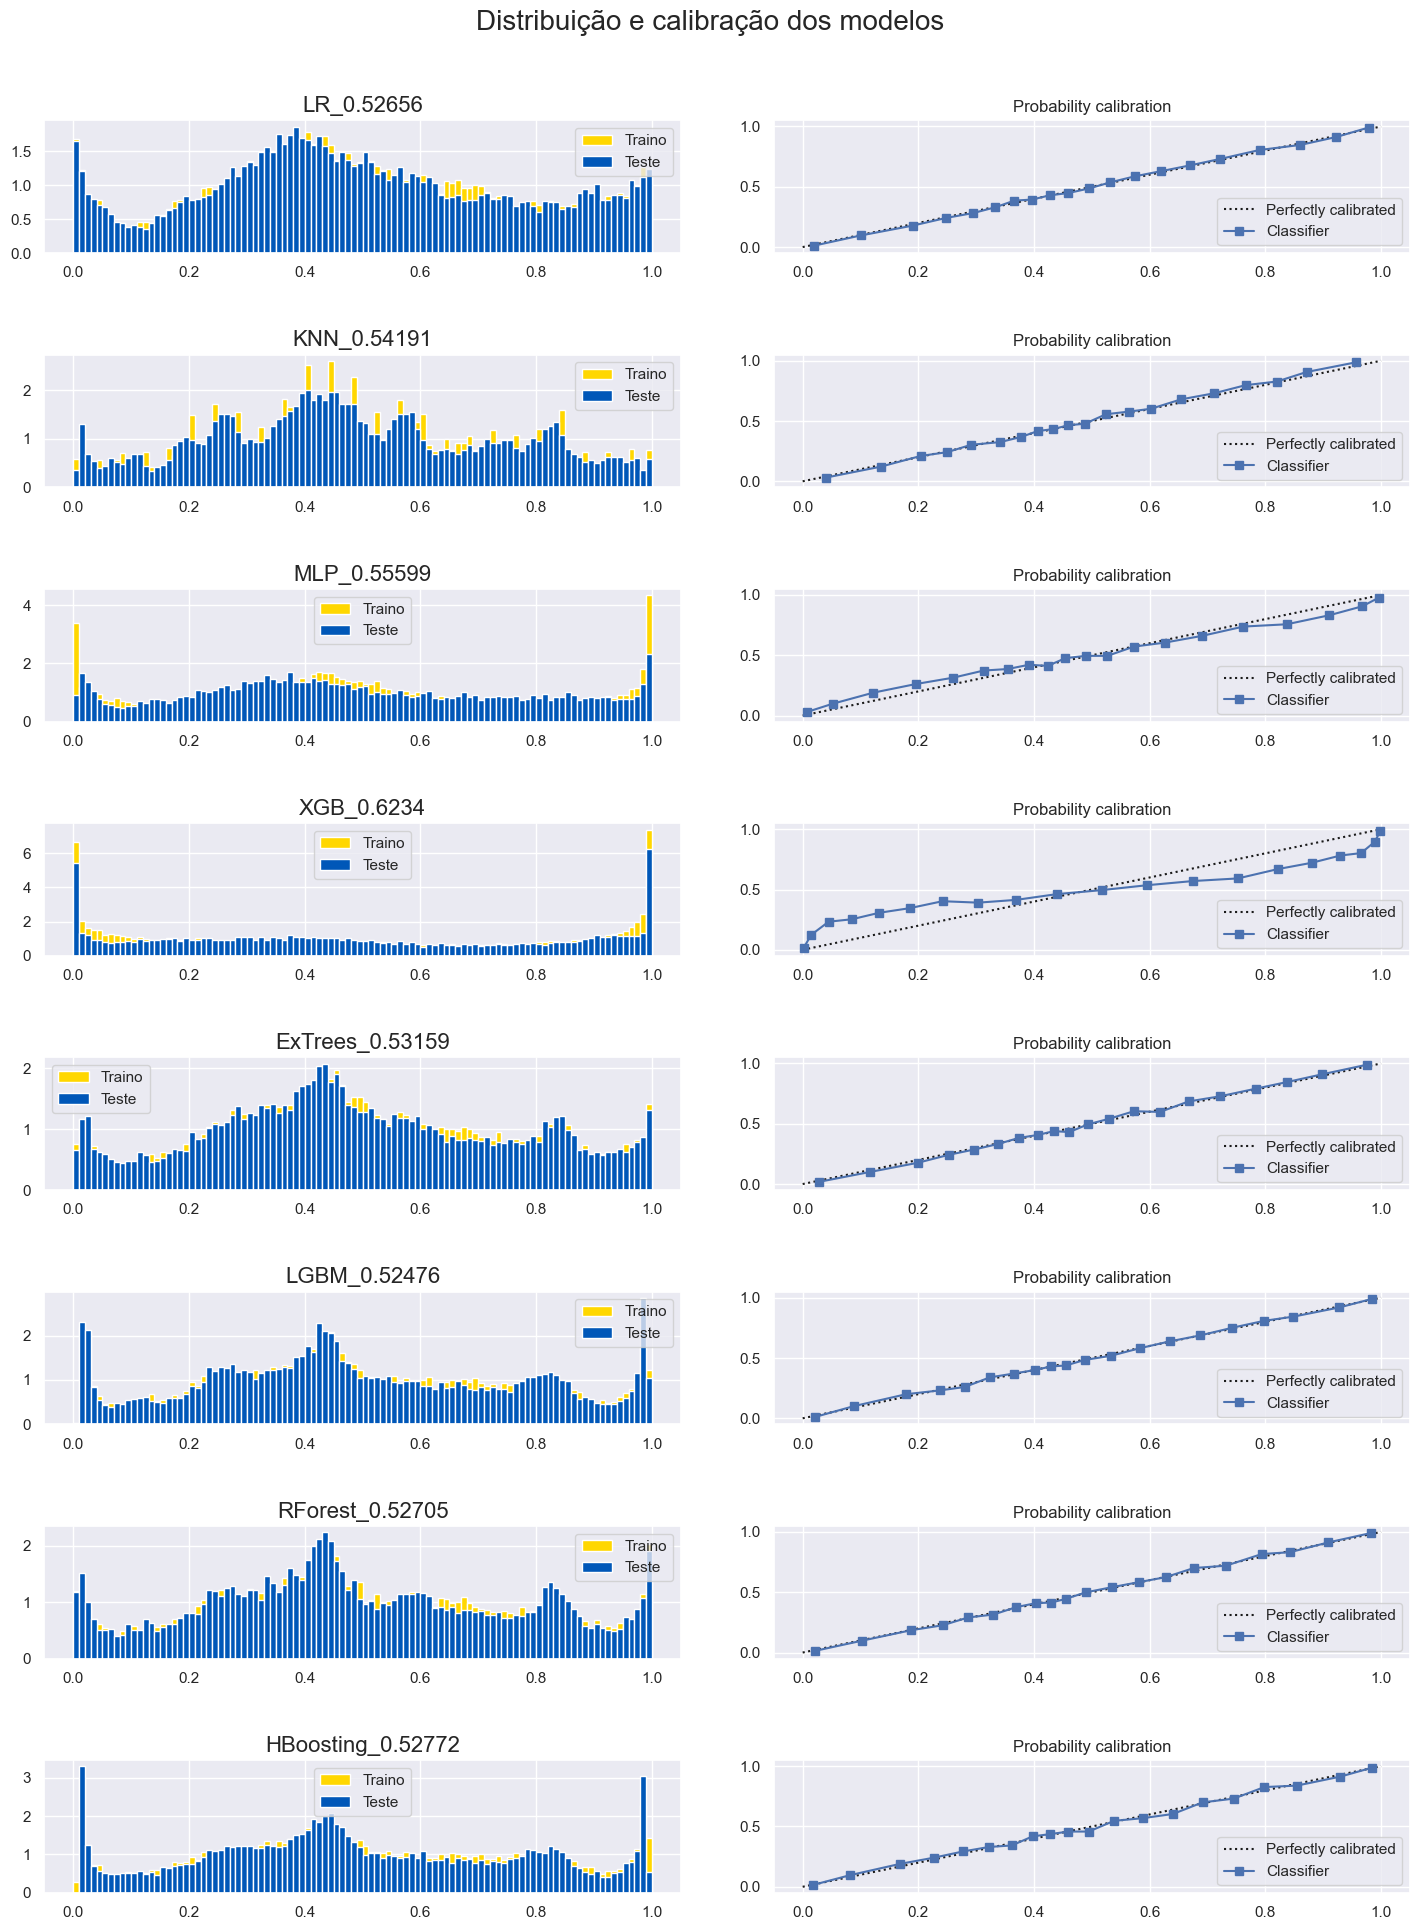

In [98]:
cols = df_pred_tr.columns
row  = int(len(cols))

fig, axs = plt.subplots(row, 2, figsize=(15, 20)) 

for i, col in enumerate(cols):     
    axs[i][0].hist(df_pred_tr[col], range=(0, 1), bins=100, density=True, color='#ffd700', label='Traino')
    axs[i][0].hist(df_pred_ts[col], range=(0, 1), bins=100, density=True, color='#0057b8', label='Teste')
    axs[i][0].set_title(col, fontsize=16)
    axs[i][0].legend()

    CalibrationDisplay.from_predictions(y, df_pred_tr[col], ax=axs[i][1], n_bins=20, strategy='quantile', color='b')
    axs[i][1].set_title('Probability calibration')
    axs[i][1].set_xlabel('')
    axs[i][1].set_ylabel('')
        
plt.suptitle('Distribuição e calibração dos modelos', fontsize=20)
plt.tight_layout(pad=3.0);

utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

A maioria dos modelos tem um boa calibração, exceto a MLP, em relação a distribuição das previsões em ambos os datasets apresentam a mesma distribuição. Alguns modelo pondem ser melhorados com ajuste de parametros. 
    
    
</didv>

## 4.2. Correlação

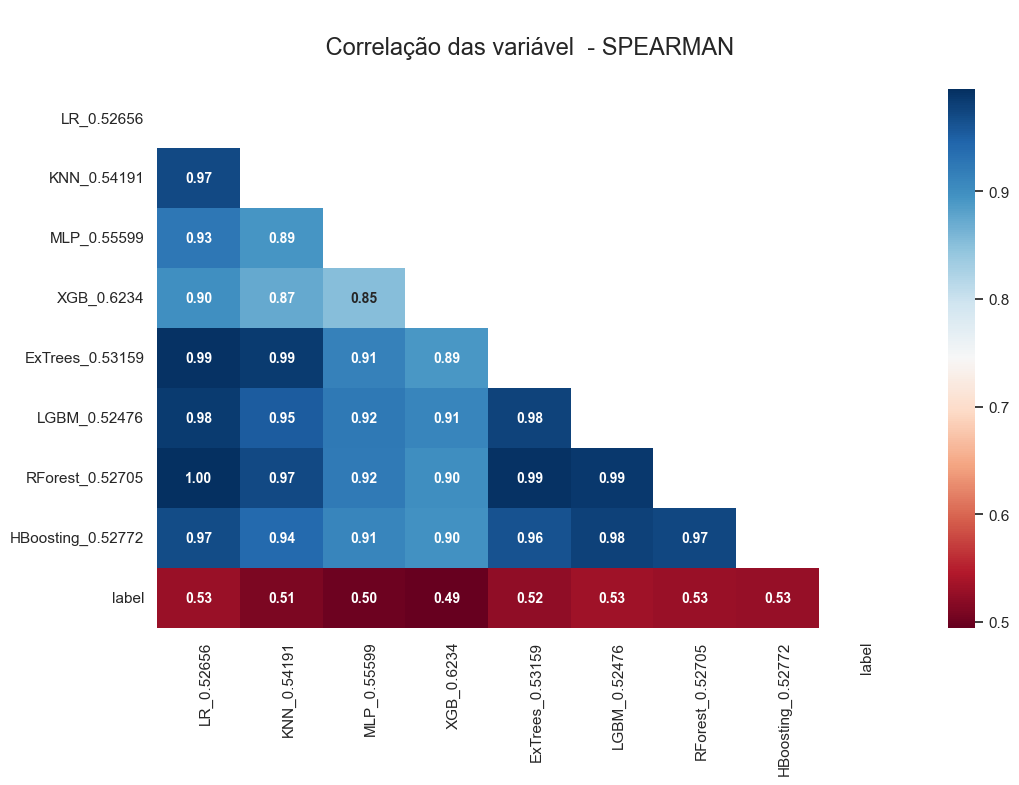

In [99]:
plt.figure(figsize=(12,7))
_ = df_pred_tr.copy() 
_[target] = y
feature_corr = \
    utility.graf_feature_corr(df_         = _,                             
                              annot_      = True, 
                              threshold_  = .8, 
                              print_var_  = False, 
                              print_graf_ = True, 
                              mask_       = True, 
                              method_     = 'spearman'
                              );
utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
Todos os modelos tem uma baixa correlação com a variável alvo, porem entre as previsões temos uma autocorreção, não vou me preocupar neste momento com essa auto correlação, pois mais tarde vamos fazer uma seleção da melhores variáveis para o próximo nível.     
    
</div>

## 4.3. Média ponderada

Vamos fazer dos modelos. 

In [89]:
def get_oof_roc_score(df_, y_, weight_, pred_model1_, pred_model2_):
    blend_pred = (df_[pred_model1_]*weight_)+(df_[pred_model2_]*(1 - weight_))
    score      = log_loss(y_, blend_pred)
    return score

In [179]:
%%time 

feature_mdl      = df_pred_tr.columns.to_list()
myscores_mdl     = []
best_mdl_score_1 = []

for mdl_1 in feature_mdl:     
    f = feature_mdl.copy() 
    f.remove(mdl_1)   
    for mdl_2 in f: 
        myscores    = {}
        best        = 1.
        best_weight = 0.

        for weight in range(100):            
            weight /= 100.
            score = get_oof_roc_score(df_          = df_pred_tr, 
                                      y_           = y,
                                      weight_      = weight, 
                                      pred_model1_ = mdl_1,  
                                      pred_model2_ = mdl_2)

            if score < best:
                best        = score
                best_weight = weight                

            myscores[weight] = score

    best_mdl_score_1.append({'model_1' : mdl_1, 
                             'model_2' : mdl_2, 
                             'score'   : round(best, 5), 
                             'weight'  : best_weight})

    msg = 'Best Weight: {:2.5f} - Score: {:2.5f} => {} - {}'
    print(msg.format(best_weight, best, mdl_1, mdl_2))  
    
_ = pd.DataFrame(best_mdl_score_1).sort_values('score')

print()
display(_)

print()

Best Weight: 0.56000 - Score: 0.52461 => LR_0.52656 - HBoosting_0.52772
Best Weight: 0.13000 - Score: 0.52731 => KNN_0.54191 - HBoosting_0.52772
Best Weight: 0.19000 - Score: 0.52628 => MLP_0.55599 - HBoosting_0.52772
Best Weight: 0.08000 - Score: 0.52726 => XGB_0.6234 - HBoosting_0.52772
Best Weight: 0.33000 - Score: 0.52635 => ExTrees_0.53159 - HBoosting_0.52772
Best Weight: 0.72000 - Score: 0.52424 => LGBM_0.52476 - HBoosting_0.52772
Best Weight: 0.53000 - Score: 0.52506 => RForest_0.52705 - HBoosting_0.52772
Best Weight: 0.47000 - Score: 0.52506 => HBoosting_0.52772 - RForest_0.52705



,model_1,model_2,score,weight
5,LGBM_0.52476,HBoosting_0.52772,0.52424,0.72
0,LR_0.52656,HBoosting_0.52772,0.52461,0.56
6,RForest_0.52705,HBoosting_0.52772,0.52506,0.53
7,HBoosting_0.52772,RForest_0.52705,0.52506,0.47
2,MLP_0.55599,HBoosting_0.52772,0.52628,0.19
4,ExTrees_0.53159,HBoosting_0.52772,0.52635,0.33
3,XGB_0.6234,HBoosting_0.52772,0.52726,0.08
1,KNN_0.54191,HBoosting_0.52772,0.52731,0.13



CPU times: total: 27.8 s
Wall time: 27.8 s


In [180]:
mdl_1 = str(_[:1].values[:,:1]).replace("[", '').replace("'",'').replace("]", '').replace("'",'')
mdl_2 = str(_[:1].values[:,1:2]).replace("[", '').replace("'",'').replace("]", '').replace("'",'')
weight = np.float64(str(_[:1].values[:,3:4]).replace("[", '').replace("'",'').replace("]", '').replace("'",''))

name = 'emsable_average_{}_{}.csv'.format(mdl_1, mdl_2)
df_submission['pred'] = df_pred_ts[mdl_1]*weight + df_pred_ts[mdl_2]*(1-weight)
df_submission.to_csv(path+'Data/submission/'+name, index=False)

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Na submissão da media ponderada do HBoosting e RForest se mostrou promissor com score de 0.51669, passando a ser melhor que a maior dos modelos. 
 
</div>

<p style="border-bottom: 2px solid #256B5D"/></p>

# 5. Terceiro Nível
Nesta parte do processo vamos pegar as previsões que foram geradas no segundo nível e fazer novas previsões com os modelos que foram utilizados. 

In [102]:
df_pred_tr.columns

Index(['LR_0.52656', 'KNN_0.54191', 'MLP_0.55599', 'XGB_0.6234',
       'ExTrees_0.53159', 'LGBM_0.52476', 'RForest_0.52705',
       'HBoosting_0.52772'],
      dtype='object')

In [103]:
df_tr = df_pred_tr.copy()
df_ts = df_pred_ts.copy()

cols_new = ['LR', 'KNN', 'MLP', 'XGB', 'ExTrees', 
            'LGBM', 'RForest','HBoosting']

df_tr.columns= cols_new
df_ts.columns= cols_new

df_tr.head()

,LR,KNN,MLP,XGB,ExTrees,LGBM,RForest,HBoosting
0,0.778304,0.675556,0.746508,0.898727,0.736471,0.692135,0.775825,0.616962
1,0.341987,0.342222,0.449314,0.263709,0.355039,0.321589,0.359551,0.314396
2,0.570497,0.573333,0.655595,0.825600,0.581522,0.587392,0.585961,0.664786
3,0.555071,0.528889,0.537479,0.748041,0.543041,0.599811,0.567551,0.601566
4,0.854616,0.826667,0.793431,0.916732,0.846234,0.828560,0.842488,0.849188


In [104]:
%%time 

models_n3 = [
    ('RForest', model_rf, 1, 'model_rf_n3'), 
    ('XGB', model_xgb, 1, 'model_xgb_n3'), 
    ('LGBM', model_lgbm, 1, 'model_lgbm_n3'), 
    ('HBoosting', model_hbc, 1, 'model_hbc_n3'), 
    ('LR', model_lr, 1, 'model_lr_n3')
]
      
# 0.51537 model_lr_02_0.52341_folds_10_oof.csv.csv - model_rf
cols = ['LR_0.52656', 'KNN_0.54191', 'MLP_0.55273', 'XGB_0.5246',
       'ExTrees_0.53159', 'LGBM_0.52414', 'RForest_0.52705',
       'HBoosting_0.52772'] 

# 0.51515 - model_lr_02_0.52365_folds_10_oof.csv.csv - model_rf
cols = ['LR_0.52656', 'KNN_0.54191', 'MLP_0.55273', 'XGB_0.5246',
       'ExTrees_0.53159', 'LGBM_0.52414', 'HBoosting_0.52772']
       
cols = ['LR', 'KNN', 'MLP', 'XGB', 'ExTrees', 
        'LGBM', 'HBoosting'] # 'RForest',

df_pred_tr_n3, df_pred_ts_n3, df_score_mdl_n3 = \
    model_cv_fit(models_       = models_n3, 
                 X_            = df_tr[cols],
                 y_            = y, 
                 X_test_       = df_ts[cols],                  
                 path_         = path, 
                 seed_         = seed,
                 target_       = 'pred',
                 create_sub_   = True, 
                 n_splits_     = 10,
                 print_report_ = True) 


=> RForest
Fold 1 => L.Loss: 0.51725 - F1-score: 0.71069 - AUC:0.72400 - 0h 0m 2s
Fold 2 => L.Loss: 0.50694 - F1-score: 0.74138 - AUC:0.74500 - 0h 0m 2s
Fold 3 => L.Loss: 0.52911 - F1-score: 0.71014 - AUC:0.72000 - 0h 0m 2s
Fold 4 => L.Loss: 0.51584 - F1-score: 0.72140 - AUC:0.73700 - 0h 0m 2s
Fold 5 => L.Loss: 0.52744 - F1-score: 0.70692 - AUC:0.71850 - 0h 0m 2s
Fold 6 => L.Loss: 0.52646 - F1-score: 0.69787 - AUC:0.71600 - 0h 0m 2s
Fold 7 => L.Loss: 0.51190 - F1-score: 0.71163 - AUC:0.72850 - 0h 0m 2s
Fold 8 => L.Loss: 0.52093 - F1-score: 0.70995 - AUC:0.72750 - 0h 0m 2s
Fold 9 => L.Loss: 0.53875 - F1-score: 0.68680 - AUC:0.70450 - 0h 0m 2s
Fold 10 => L.Loss: 0.54332 - F1-score: 0.68871 - AUC:0.70350 - 0h 0m 2s
-------------------------------------------------------------------------
[Fold Mean] L.Loss: 0.52379 - 0h 0m 22s

              precision    recall  f1-score   support

           0       0.70      0.77      0.73     10000
           1       0.75      0.68      0.71     10000

,score
RForest,0.52379
LGBM,0.52567
HBoosting,0.52685
LR,0.53154
XGB,0.55606



CPU times: total: 2min 43s
Wall time: 43.2 s


## 5.1. Distribuição e calibração

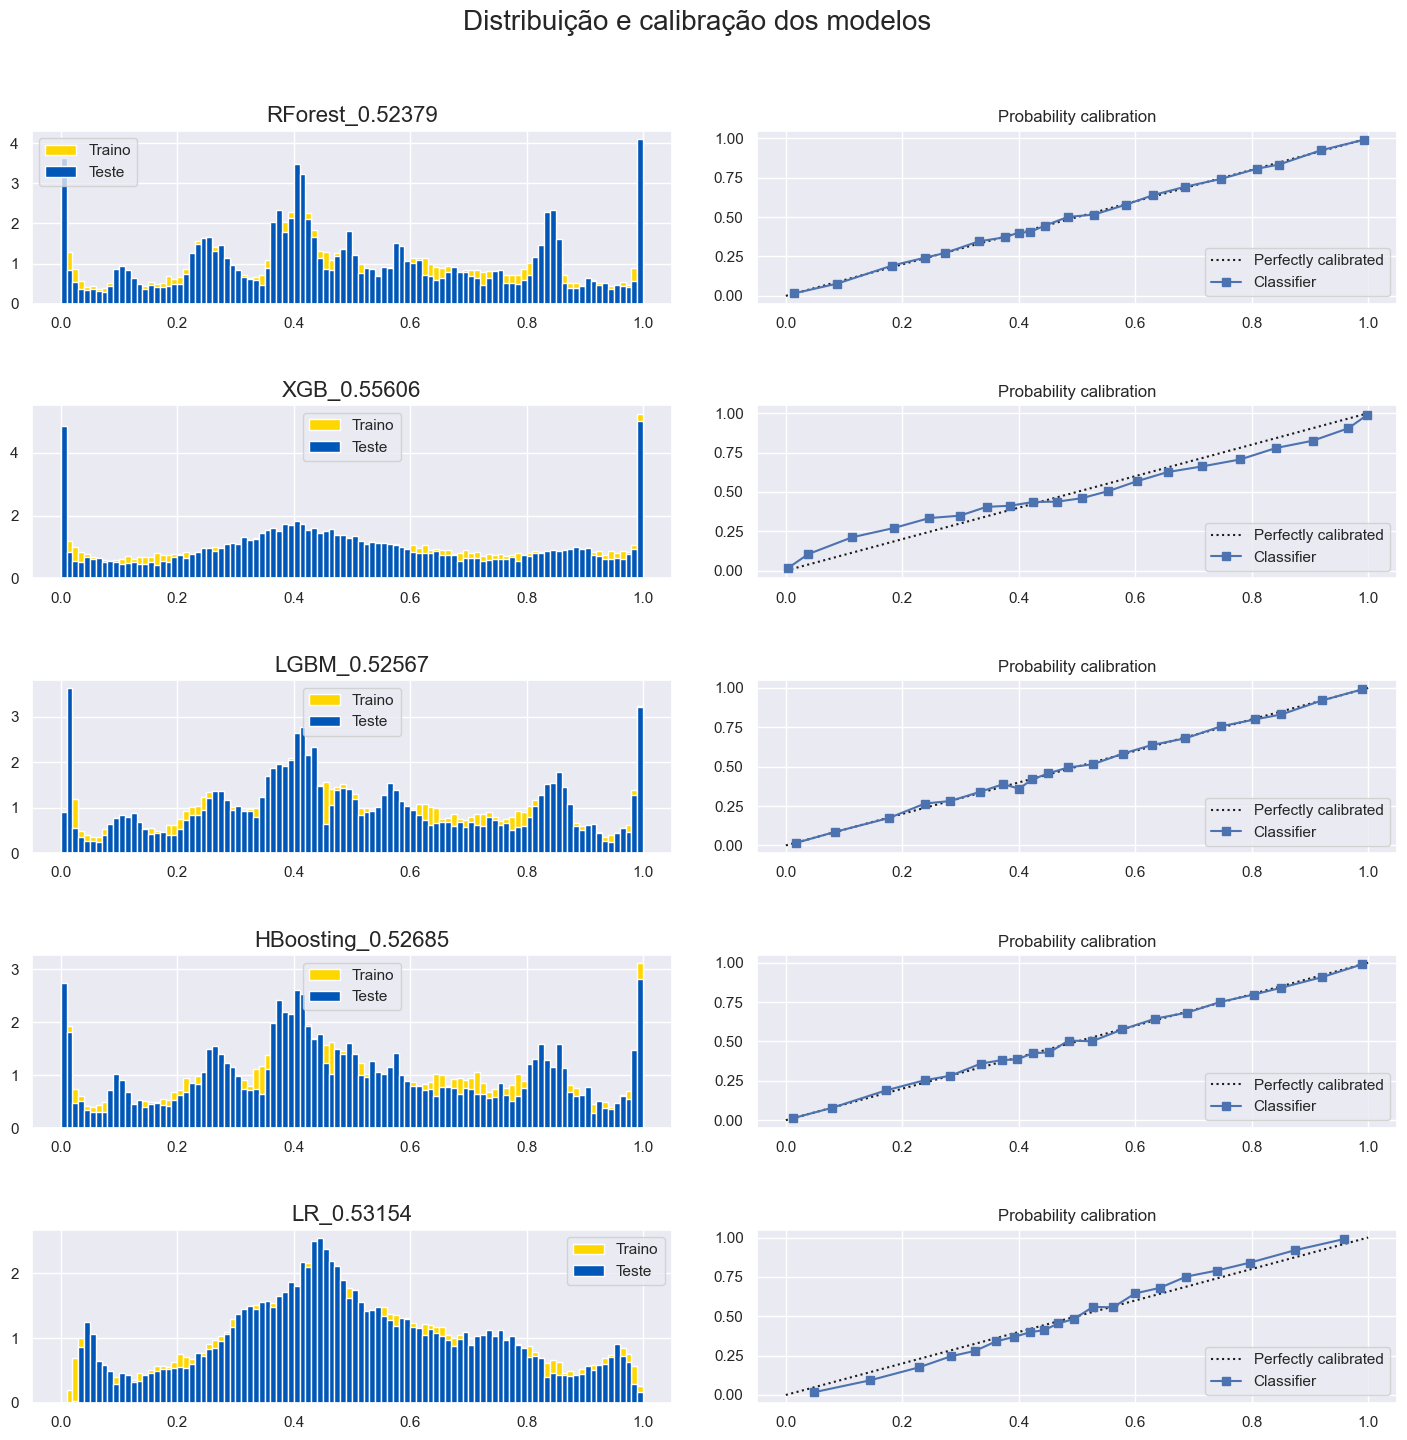

In [105]:
cols = df_pred_tr_n3.columns
row  = int(len(cols))

fig, axs = plt.subplots(row, 2, figsize=(15, 15)) 

for i, col in enumerate(cols):     
    axs[i][0].hist(df_pred_tr_n3[col], range=(0, 1), bins=100, density=True, color='#ffd700', label='Traino')
    axs[i][0].hist(df_pred_ts_n3[col], range=(0, 1), bins=100, density=True, color='#0057b8', label='Teste')
    axs[i][0].set_title(col, fontsize=16)
    axs[i][0].legend()

    CalibrationDisplay.from_predictions(y, df_pred_tr_n3[col], ax=axs[i][1], n_bins=20, strategy='quantile', color='b')
    axs[i][1].set_title('Probability calibration')
    axs[i][1].set_xlabel('')
    axs[i][1].set_ylabel('')
        
plt.suptitle('Distribuição e calibração dos modelos', fontsize=20)
plt.tight_layout(pad=3.0);

utility.free_gpu_cache()

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
   
Observamos que a distribuição dos datasets(treino/teste) seguem a mesma distribuição, porém com a maioria das probabilidade entre 0.2 e 0.8, ainda temos um espaço para melhoria. Em relação a calibração a maioria dos modelos tem uma boa calibragem, exceto LR e XGB. <p>

A melhor submissão foi RForest que bateu score da minha LB.

</div> 

In [106]:
cols_n3 = ['RForest', 'XGB', 'LGBM', 'HBoosting', 'LR' ] 
df_pred_ts_n3.columns= cols_n3
df_pred_ts_n3.head()

,RForest,XGB,LGBM,HBoosting,LR
0,0.548317,0.565669,0.569752,0.551179,0.535877
1,0.661856,0.536297,0.644781,0.607051,0.632864
2,0.232247,0.146684,0.224212,0.222223,0.301625
3,0.366181,0.351043,0.355033,0.365944,0.414383
4,0.041207,0.011271,0.046439,0.046321,0.121068


In [107]:
name = 'sub_emsable_RForest_LGBM_n3.csv'
df_submission['pred'] = df_pred_ts_n3['RForest']*.9 + df_pred_ts_n3['LGBM'] *.1
df_submission.to_csv(path+'Data/submission/'+name, index=False)
# kaggle 0.51522 => sub_emsable_RForest_LGBM_n3.csv

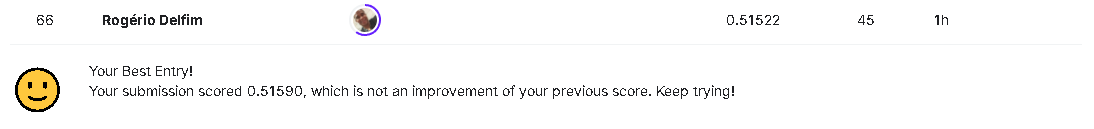

<p style="border-bottom: 2px solid #256B5D"/></p>

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 5. CONCLUSÃO </h1>    
</div>

<div class="alert alert-block alert-info" style="border-radius:15px">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Neste notebook, fizemos uma penaque análise dos dados, podemos destacar os seguintes: 

- Os dados não tem valores nulos e são balaceddos, sendo assim, não precisamos nos preocupar em imputar valores ausentes e fazer o balanceamento dos dados, provavelmente isso foi feito anteriormente; <p>

- Alguns das previsões tem valores descrepantes em relação a métrica de avaliação, valores abaixo de 0 e acima 1, sendo assim , fizemos correção dentro da validação cruzada com a utilizando um <b>eps</b>, isto é, parâmetro que corta as probalidades automaticamente para que não haja problema com a métrica de avarição; <p>
    
- Temos pouco sinais de overfitting, o que gerou melhorias dos scores nas submissões; <p>

- Utilizamos um pipeline de treinamento, o qual fazemos a exclusão das variáveis com pouca relevância para a modelagem e um pré-processamento para alguns modelos; <p>
    
- Utilizamos uma validação cruzada de 10 folds, o que se mostrou mais promissor gerando melhores scores nos treinamento e estabilidade; <p>

- O melhor modelo foi o <b>LGBM</b> entre os modelos utiliados, utilizamos algumas médias ponderadas que se mostraram melhores que alguns modelos, mas não bateram o score da <b>LGBM</b>. Para bater o score da <b>LGBM</b>, treinei o modelo <b>LogisticRegression</b> nas previsões que geradas pelos modelos e consegui superar o score da <b>LGBM</b>.  

<p><br>
    
     
<b>PRÓXIMOS PASSOS:</b> <br>   
- Fazer tunning dos parametros e novos modelos no segundo nível;
- Acrescentar as previsões geradas e fazer uma seleção das variáveis utilizando permutação.
 
    
    
</div>